### Feature Engineering


- 특징
    - 시간 개념 feature를 추가 생성
        - 비어있는 값이 있을 수도 있기에 비어있지 않는 시간 데이터를 생성한 후 진행

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sklearn.ensemble import RandomForestRegressor
import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='new-york-taxi-309501'

In [2]:
ex = Experiment('nyc-demand-prediction', interactive=True)

experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

In [3]:
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
), distinct_datetime AS (
  # Datetime만 distinct해서 가져옴(비어있지 않을것이라 가정)
  SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
  FROM base_data
), distinct_zip_code AS (
  # zip_code만 distinct해서 가져옴(이외의 zip_code는 나오지 않을것이라 가정)
  SELECT distinct zip_code
  FROM base_data
), zip_code_datetime_join AS (
  # zip_code와 datetime을 join
  SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
  FROM distinct_zip_code  
  CROSS JOIN distinct_datetime
), agg_data AS (
  # zip_code, datetime별 수요 
  SELECT 
      zip_code,
      DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
      COUNT(*) AS cnt
  FROM base_data 
  GROUP BY zip_code, pickup_hour
), join_output AS (
  # zip_code, datetime 데이터에 수요값을 붙이고 없다면 0처리
  select 
    zip_code_datetime.*, 
    IFNULL(agg_data.cnt, 0) AS cnt
  from zip_code_datetime_join as zip_code_datetime
  LEFT JOIN agg_data
  ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)
SELECT
  *,
  LAG(cnt, 1) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1h_cnt,
  LAG(cnt, 24) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1d_cnt,
  LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
  LAG(cnt, 336) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING), 2) AS avg_21d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_14d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING) AS INT64) AS std_21d_cnt
FROM join_output
order by zip_code, pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id='new-york-taxi-309501')

Downloading: 100%|█████████████████████████████████████████████████████████| 278256/278256 [00:28<00:00, 9929.52rows/s]


In [4]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt
278251,14801,2015-01-31 19:00:00,1,31,5,19,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278252,14801,2015-01-31 20:00:00,1,31,5,20,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278253,14801,2015-01-31 21:00:00,1,31,5,21,1,0,0.0,1.0,0.0,0.0,0.01,0.0,0.0,0.0
278254,14801,2015-01-31 22:00:00,1,31,5,22,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278255,14801,2015-01-31 23:00:00,1,31,5,23,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0


In [5]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [6]:
def train_test_split(df, date):
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### train/ test 데이터 분리

In [7]:
train_df, test_df = train_test_split(base_df,'2015-01-24')

In [8]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
278059,14801,2015-01-23 19:00:00,1,23,4,19,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278060,14801,2015-01-23 20:00:00,1,23,4,20,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278061,14801,2015-01-23 21:00:00,1,23,4,21,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278062,14801,2015-01-23 22:00:00,1,23,4,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278063,14801,2015-01-23 23:00:00,1,23,4,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373


In [9]:
test_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
552,10001,2015-01-24 00:00:00,1,24,5,0,1,1167,1274.0,884.0,1256.0,1164.0,893.04,915.80,412.0,427.0,0
553,10001,2015-01-24 01:00:00,1,24,5,1,1,887,1167.0,497.0,950.0,969.0,892.51,915.81,411.0,427.0,0
554,10001,2015-01-24 02:00:00,1,24,5,2,1,715,887.0,332.0,836.0,874.0,892.13,915.57,411.0,427.0,0
555,10001,2015-01-24 03:00:00,1,24,5,3,1,532,715.0,229.0,686.0,634.0,891.41,915.10,411.0,428.0,0
556,10001,2015-01-24 04:00:00,1,24,5,4,1,315,532.0,177.0,515.0,545.0,890.49,914.79,412.0,428.0,0


In [10]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [11]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')
x_train = train_df.copy()
x_test = test_df.copy()

In [14]:
train_df = train_df.fillna(method='bfill')
test_df = test_df.fillna(method='backfill')

In [15]:
x_train = train_df.copy()
x_test = test_df.copy()

In [12]:
len(x_train)

206448

In [13]:
len(x_test)

71808

### 모델링

In [16]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [17]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [18]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)

In [19]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()

In [20]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "12"
INFO - nyc-demand-prediction - Result: {'mape': {'score': nan}, 'mae': {'score': 6.986561385918004}, 'mse': {'score': 1022.2682542335117}}
INFO - nyc-demand-prediction - Completed after 0:00:01


In [21]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 95202352}

In [22]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

### 결과 분석

In [28]:
parsing_output(3)

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,3,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",57.678736,538.520173,16512.330211


In [29]:
parsing_output(4)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,4,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",47.991885,410.699962,13871.771004


In [30]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 620...",35.342307,186.504817,12177.745069


In [31]:
parsing_output(12)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,12,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 952...",6.986561,None,1022.268254


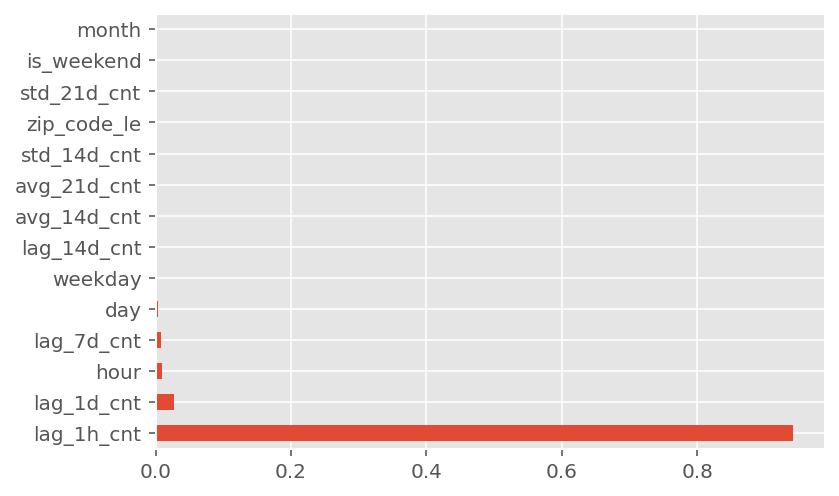

In [32]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

### 데이터 복구

In [34]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

INFO - numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - numexpr.utils - NumExpr defaulting to 8 threads.


In [35]:
test_df = test_df.set_index('datetime')

### datetime 별 차이

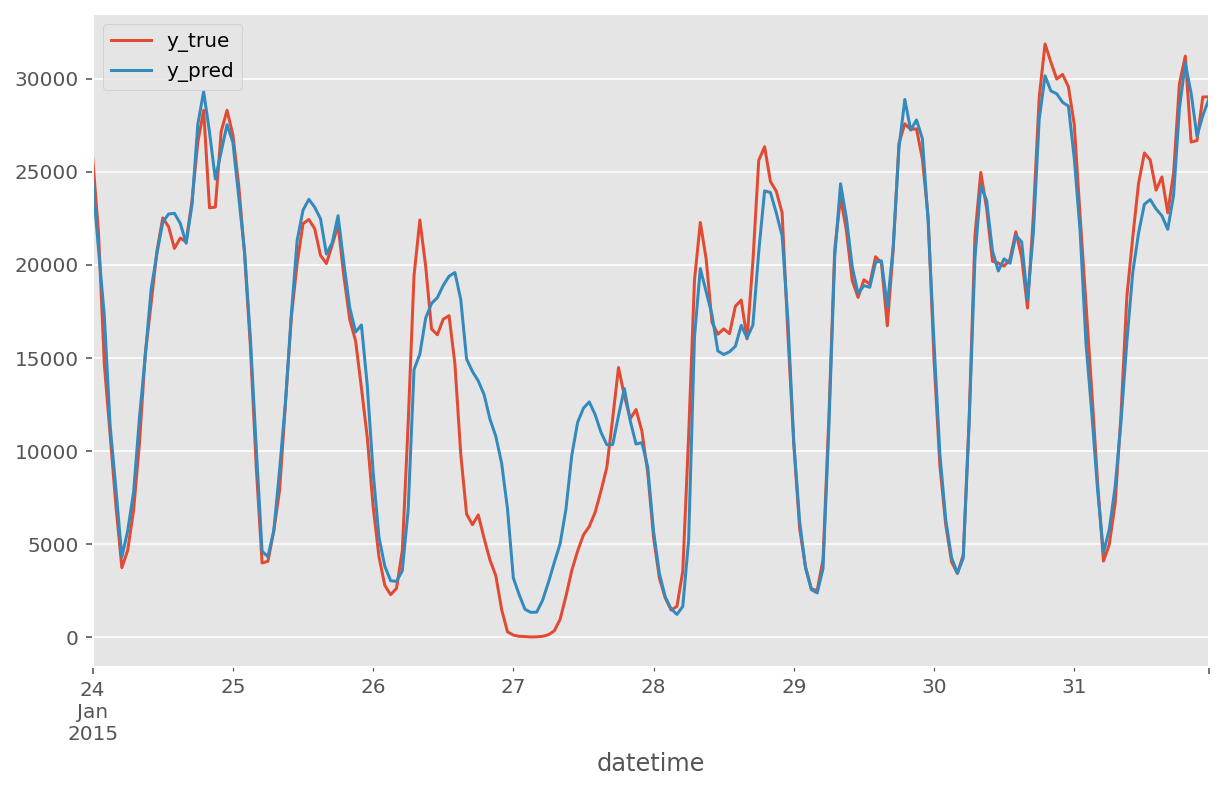

In [37]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot(figsize=(10,6))

### zip_code별 차이

In [40]:
def visual_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true','y_pred']]
        try:
            ax = data.plot(figsize=(10,6))
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

In [41]:
visual_output_by_zipcode(test_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

### hour별 차이

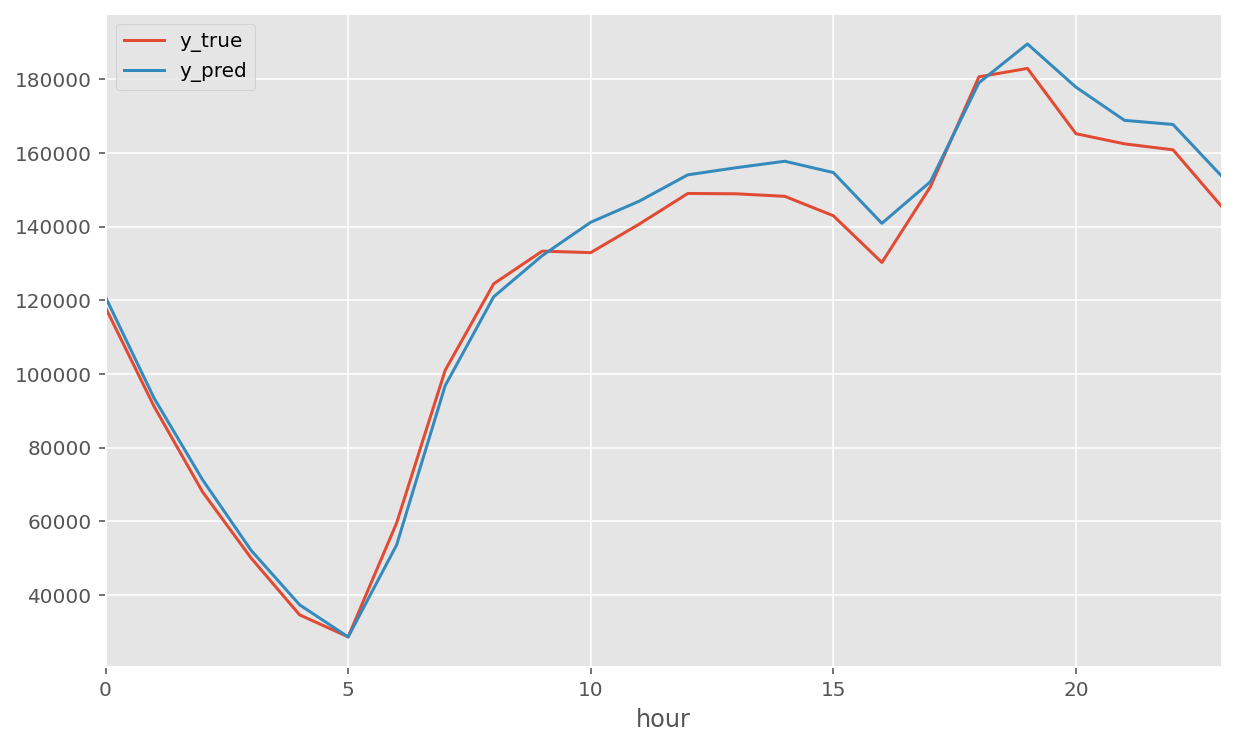

In [48]:
test_df.groupby('hour').sum()[['y_true', 'y_pred']].plot(figsize=(10,6))

In [46]:
test_df.groupby('hour').sum()[['y_true', 'y_pred']]

,y_true,y_pred
hour,,
0,118017,120862.6
1,91196,93449.7
2,67973,71271.8
3,50021,52123.5
4,34603,37327.9
5,28638,28605.4
6,59575,53592.5
7,100996,96822.3
8,124475,120952.6


### Weekday별 차이

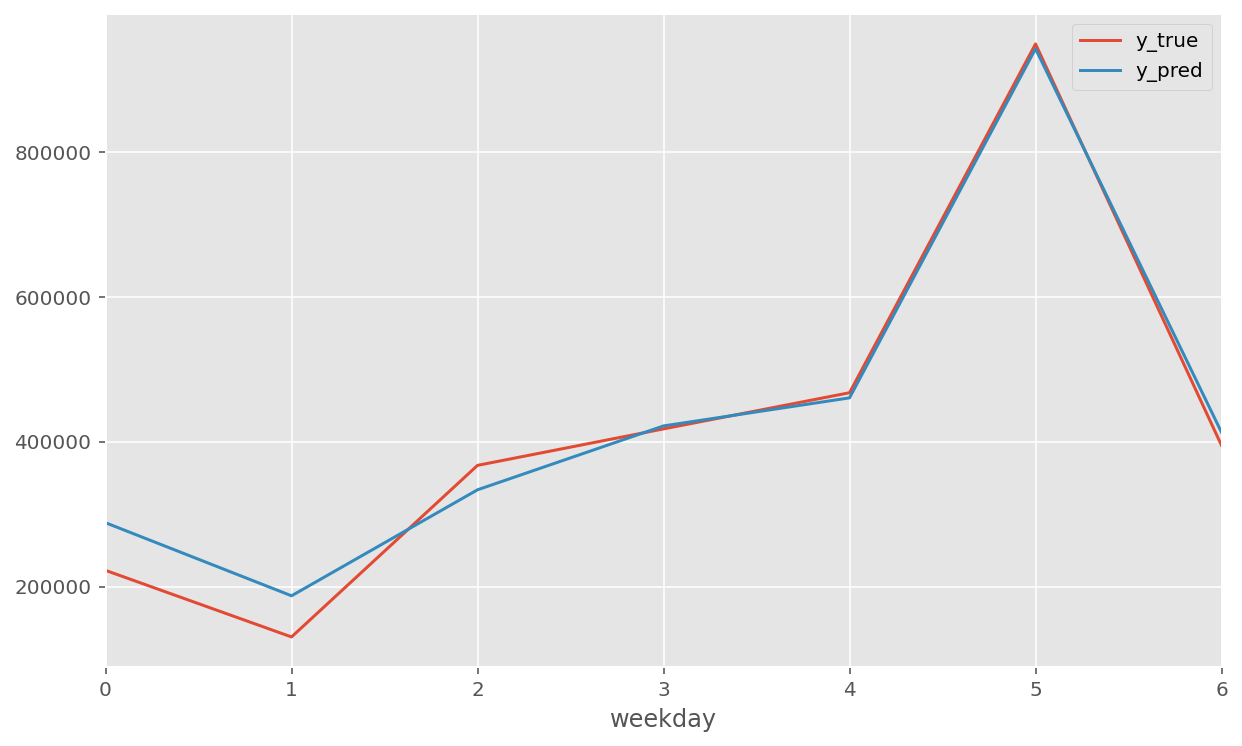

In [50]:
test_df.groupby('weekday').sum()[['y_true', 'y_pred']].plot(figsize=(10,6));

In [51]:
test_df.groupby('weekday').sum()[['y_true', 'y_pred']]

,y_true,y_pred
weekday,,
0,222332,288149.7
1,130322,187181.4
2,367404,333651.6
3,417795,421905.8
4,467775,460674.7
5,949717,943049.9
6,394938,412966.1


### 평일/주말별 차이

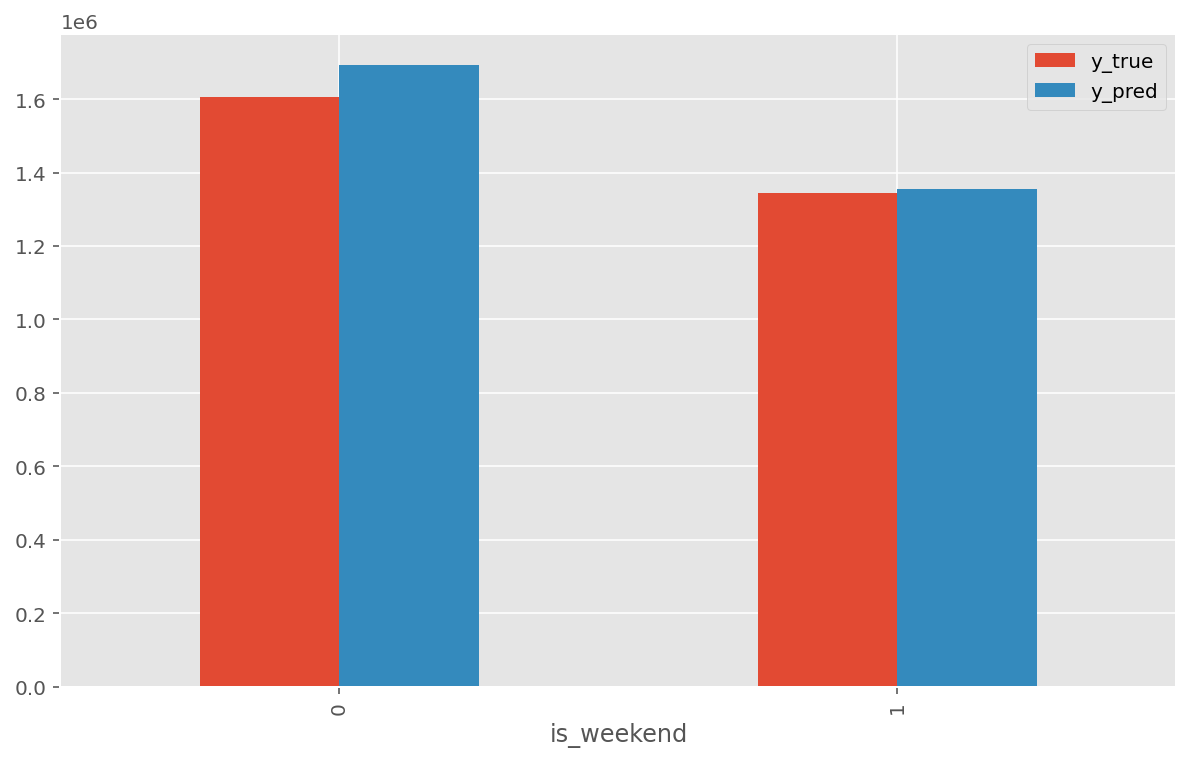

In [53]:
test_df.groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar',figsize=(10,6))